# Pretraining a Customer Support Model on X (former Twitter)
copyright 2023, Denis Rothman

**Pretraining a Generative AI model from scratch**

**Dataset:**Tweets from 20 Top Brands by Volume  
**Model:**  RobertaForCausalLM

![](https://i.imgur.com/nTv3Iuu.png)




The goal of the notebook is to train a Hugging Face RobertaForCausalLM model to simulate a customer support chat agent for X (former Twitter)

This notebook requires a GPU.

**Customer Support on Twitter**
Over 2 million tweets and replies from the biggest brands on Twitter

https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter

**Limitations**: The scope of pretraining was limited to a subset of the dataset for time constraints. You can train the full dataset on Google Colab or another platform. You can also select another model if you find the generalized reponses insufficient.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kaggle credentials for authentification

In [ ]:
import os
import json
with open(os.path.expanduser("drive/MyDrive/files/kaggle.json"), "r") as f:
    kaggle_credentials = json.load(f)

kaggle_username = kaggle_credentials["username"]
kaggle_key = kaggle_credentials["key"]

os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

In [ ]:
try:
  import kaggle
except:
  !pip install kaggle
  import kaggle

In [ ]:
kaggle.api.authenticate()

#Step 1.Downloading the dataset

https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter

In [ ]:
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

 97% 164M/169M [00:05<00:00, 39.4MB/s]
100% 169M/169M [00:05<00:00, 29.8MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/customer-support-on-twitter.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("File Unzipped!")

File Unzipped!


#Step 2: Installing Hugging Face transformers

April 2023 update From Hugging Face Issue 22816:

https://github.com/huggingface/transformers/issues/22816

"The PartialState import was added as a dependency on the transformers development branch yesterday. PartialState was added in the 0.17.0 release in accelerate, and so for the development branch of transformers, accelerate >= 0.17.0 is required.

Downgrading the transformers version removes the code which is importing PartialState."

Denis Rothman: The following cell imports the latest version of Hugging Face transformers but without downgrading it.

To adapt to the Hugging Face upgrade, A GPU accelerator was activated using the Google Colab Pro with the following NVIDIA GPU:
GPU Name: NVIDIA A100-SXM4-40GB

In [ ]:
!pip install Transformers
!pip install --upgrade accelerate
from accelerate import Accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.6 MB/s eta 0:00:00


creating subdirectories to store the datasets, the logs and the trained model

In [ ]:
!mkdir -p /content/model/dataset/
!mkdir -p /content/model/model/
!mkdir -p /content/model/logs/

# Step 3 Loading and filtering the data

We will use a subset of the dataset to train the model.

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/twcs/twcs.csv')

# Check the first few rows to understand the data
print(df.head())

   tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.                 4   

   in_response_to_tweet_id  
0                      3.0  
1                      1.0  
2                      4.0  
3                      5.0  
4

Extracting relevant data

In this case, we are extracting the text

In [ ]:
# Extract tweets from the 'text' column or any other relevant column
tweets = df['text'].dropna().tolist()  # This assumes the column with tweets is named 'text'

In [ ]:
# Convert the list of tweets to a DataFrame
df_tweets = pd.DataFrame(tweets, columns=['text'])

# Save the DataFrame to a CSV file
df_tweets.to_csv('tweets.csv', index=False, encoding='utf-8')

In [ ]:
# Checking the length of df
formatted_length = "{:,}".format(len(df_tweets))
print(formatted_length)

2,811,774


Checking the extraction

In [ ]:
for tweet in tweets[:10]:  # This will display the first 5 tweets
    print(tweet)

@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.
@sprintcare and how do you propose we do that
@sprintcare I have sent several private messages and no one is responding as usual
@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.
@sprintcare I did.
@115712 Can you please send us a private message, so that I can gain further details about your account?
@sprintcare is the worst customer service
@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC
@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯
@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA


filtering the extraction to clean it and apply lowercase conversion

In [ ]:
import re

def filter_tweet(tweet):
    # Keep only characters a to z, spaces, and apostrophes, then convert to lowercase
    return re.sub(r'[^a-z\s\']', '', tweet.lower())

filtered_tweets = [filter_tweet(tweet) for tweet in tweets]

In [ ]:
f=30
filtered_tweets = [tweet for tweet in filtered_tweets if len(tweet.split()) > f]  # Only keep tweets with more than one word

In [ ]:
for filtered_tweet in filtered_tweets[:10]:  # This will display the first 5 tweets
    print(filtered_tweet)

marksandspencer i check with the gov office and legal they stated you are not right but its funny how the other stores dont but you do no wonder lidl and the rest are beating you
marksandspencer ou must charge at least p a bag including vat for carrier bags that are all of the following

unused  its new and hasnt already been used for sold goods to be taken away or delivered
plastic and  microns thick or less
it has handles an opening and isnt sealed
marksandspencer arent require charge  a bag
paper bags
shops in airports or on board trains aeroplanes or ships
bags which only contain certain items such as unwrapped food raw meat and fish where there is a food safety risk prescription medicines uncovered blades seeds bulbs amp s
 hi you can change your microsoft account email through the steps here httpstcodkehohboyy  if the email your son wants to change to is already associated with a microsoft account you'll need to follow those steps to switch the email address on that account too z

In [ ]:
# Checking the length of dataset
formatted_length = "{:,}".format(len(filtered_tweets))
print(formatted_length)

228,637


save the dataset

In [ ]:
import csv
# Save to CSV
with open('/content/model/dataset/processed_tweets.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for tweet in filtered_tweets:
        writer.writerow([tweet])

check the file

In [ ]:
import csv

# Read from CSV
with open('/content/model/dataset/processed_tweets.csv', 'r') as file:
    reader = csv.reader(file)

    # Use islice from itertools to only get the first 5 lines
    from itertools import islice
    for row in islice(reader, 5):
        print(row[0])

marksandspencer i check with the gov office and legal they stated you are not right but its funny how the other stores dont but you do no wonder lidl and the rest are beating you
marksandspencer ou must charge at least p a bag including vat for carrier bags that are all of the following

unused  its new and hasnt already been used for sold goods to be taken away or delivered
plastic and  microns thick or less
it has handles an opening and isnt sealed
marksandspencer arent require charge  a bag
paper bags
shops in airports or on board trains aeroplanes or ships
bags which only contain certain items such as unwrapped food raw meat and fish where there is a food safety risk prescription medicines uncovered blades seeds bulbs amp s
 hi you can change your microsoft account email through the steps here httpstcodkehohboyy  if the email your son wants to change to is already associated with a microsoft account you'll need to follow those steps to switch the email address on that account too z

#Step 4: Checking Resource Constraints: GPU and NVIDIA

In [ ]:
!nvidia-smi

Fri Sep 29 10:07:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Checking that PyTorch Sees CUDA
import torch
torch.cuda.is_available()

True

#Step 5: Defining the configuration of the model

In [ ]:
from transformers import RobertaConfig, RobertaForCausalLM

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    is_decoder=True,  # Set up the model for potential seq2seq use, allowing for autoregressive outputs
)

In [ ]:
print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



define and print model

In [ ]:
# Create the RobertaForCausalLM model with the specified config
model = RobertaForCausalLM(config=config)
print(model)

RobertaForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

##  defining the tokenizer

In [ ]:
from transformers import RobertaTokenizer

# Initialize the tokenizer using the 'roberta-base' pre-trained model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
# Display special tokens
print("Special tokens:", tokenizer.special_tokens_map)

Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}


## Exploring the parameters

In [ ]:
print(model.num_parameters())

83504416


In [ ]:
LP=list(model.parameters())
lp=len(LP)
print(lp)
for p in range(0,lp):
  print(LP[p])

106
Parameter containing:
tensor([[-0.0066, -0.0209,  0.0061,  ...,  0.0241,  0.0179, -0.0180],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0137,  0.0183,  0.0051,  ..., -0.0162, -0.0022, -0.0295],
        ...,
        [ 0.0193,  0.0047,  0.0131,  ...,  0.0303, -0.0099,  0.0221],
        [-0.0260,  0.0480, -0.0269,  ..., -0.0179, -0.0246, -0.0220],
        [ 0.0341,  0.0232, -0.0182,  ...,  0.0076, -0.0134,  0.0082]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0217, -0.0279, -0.0187,  ..., -0.0008,  0.0007,  0.0071],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0475,  0.0033, -0.0133,  ...,  0.0018,  0.0163, -0.0291],
        ...,
        [ 0.0378, -0.0181, -0.0055,  ...,  0.0075,  0.0172, -0.0179],
        [-0.0105,  0.0207, -0.0117,  ..., -0.0038,  0.0147,  0.0257],
        [-0.0104,  0.0153,  0.0080,  ...,  0.0167, -0.0105,  0.0072]],
       requires_grad=True)
Parameter containing:
tensor([

In [ ]:
#Shape of each tensor in the model
LP = list(model.parameters())
for i, tensor in enumerate(LP):
    print(f"Shape of tensor {i}: {tensor.shape}")

Shape of tensor 0: torch.Size([52000, 768])
Shape of tensor 1: torch.Size([514, 768])
Shape of tensor 2: torch.Size([1, 768])
Shape of tensor 3: torch.Size([768])
Shape of tensor 4: torch.Size([768])
Shape of tensor 5: torch.Size([768, 768])
Shape of tensor 6: torch.Size([768])
Shape of tensor 7: torch.Size([768, 768])
Shape of tensor 8: torch.Size([768])
Shape of tensor 9: torch.Size([768, 768])
Shape of tensor 10: torch.Size([768])
Shape of tensor 11: torch.Size([768, 768])
Shape of tensor 12: torch.Size([768])
Shape of tensor 13: torch.Size([768])
Shape of tensor 14: torch.Size([768])
Shape of tensor 15: torch.Size([3072, 768])
Shape of tensor 16: torch.Size([3072])
Shape of tensor 17: torch.Size([768, 3072])
Shape of tensor 18: torch.Size([768])
Shape of tensor 19: torch.Size([768])
Shape of tensor 20: torch.Size([768])
Shape of tensor 21: torch.Size([768, 768])
Shape of tensor 22: torch.Size([768])
Shape of tensor 23: torch.Size([768, 768])
Shape of tensor 24: torch.Size([768])
Sh

In [ ]:
#counting the parameters
np=0
for p in range(0,lp):#number of tensors
  PL2=True
  try:
    L2=len(LP[p][0]) #check if 2D
  except:
    L2=1             #not 2D but 1D
    PL2=False
  L1=len(LP[p])
  L3=L1*L2
  np+=L3             # number of parameters per tensor
  if PL2==True:
    print(p,L1,L2,L3)  # displaying the sizes of the parameters
  if PL2==False:
    print(p,L1,L3)  # displaying the sizes of the parameters

print(np)              # total number of parameters

0 52000 768 39936000
1 514 768 394752
2 1 768 768
3 768 768
4 768 768
5 768 768 589824
6 768 768
7 768 768 589824
8 768 768
9 768 768 589824
10 768 768
11 768 768 589824
12 768 768
13 768 768
14 768 768
15 3072 768 2359296
16 3072 3072
17 768 3072 2359296
18 768 768
19 768 768
20 768 768
21 768 768 589824
22 768 768
23 768 768 589824
24 768 768
25 768 768 589824
26 768 768
27 768 768 589824
28 768 768
29 768 768
30 768 768
31 3072 768 2359296
32 3072 3072
33 768 3072 2359296
34 768 768
35 768 768
36 768 768
37 768 768 589824
38 768 768
39 768 768 589824
40 768 768
41 768 768 589824
42 768 768
43 768 768 589824
44 768 768
45 768 768
46 768 768
47 3072 768 2359296
48 3072 3072
49 768 3072 2359296
50 768 768
51 768 768
52 768 768
53 768 768 589824
54 768 768
55 768 768 589824
56 768 768
57 768 768 589824
58 768 768
59 768 768 589824
60 768 768
61 768 768
62 768 768
63 3072 768 2359296
64 3072 3072
65 768 3072 2359296
66 768 768
67 768 768
68 768 768
69 768 768 589824
70 768 768
71 768 768

# Step 6 Creating and processing the dataset

In [ ]:
#installing Hugging Face datasets for data loading and preprocessing
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00


In [ ]:
#load dataset
from datasets import load_dataset
dataset = load_dataset('csv', data_files='/content/model/dataset/processed_tweets.csv', column_names=["text"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# split datasets into rain and eval
from datasets import DatasetDict

dataset = dataset['train'].train_test_split(test_size=0.1)  # 10% for evaluation
dataset = DatasetDict(dataset)

In [ ]:
# Tokenize datasets:
# - If a record's length is less than `max_length`, it's padded to ensure all records have the same length.
# - If a record's length exceeds `max_length`, it's truncated to the specified max length.

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/205773 [00:00<?, ? examples/s]

Map:   0%|          | 0/22864 [00:00<?, ? examples/s]

In [ ]:
# datacollator to batch items together for training and evaluation
from transformers import DataCollatorForLanguageModeling

# Define the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # For causal (autoregressive) language modeling
)

# Step 7: Initializing the trainer

The number of epochs can be empirically increased until the
accuracy versus training time reaches a limit.

In [ ]:
# to display the time every x steps suring training
from transformers import Trainer
from datetime import datetime
from typing import Dict, Any

class CustomTrainer(Trainer):
    def log(self, logs: Dict[str, Any]) -> None:
        super().log(logs)
        if "step" in logs:  # Check if "step" key is in the logs dictionary
            step = int(logs["step"])
            if step % self.args.eval_steps == 0:
                print(f"Current time at step {step}: {datetime.now()}")

In [ ]:
import logging
from transformers import Trainer, TrainingArguments

# Set up Python logging
logging.basicConfig(level=logging.INFO)

training_args = TrainingArguments(
    output_dir="/content/model/model/",
    overwrite_output_dir=True,
    num_train_epochs=2,                  # can be increased to increase accuracy if productive
    per_device_train_batch_size=64,      # batch size per device
    save_steps=10_000,                   # save a checkpoint every save_steps=10000
    save_total_limit=2,                  # the maximum number of checkpoint model files to keep
    logging_dir='/content/model/logs/',  # directory for storing logs
    logging_steps=100,                   # Log every 100 steps
    logging_first_step=True,             # Log the first step
    evaluation_strategy="steps",         # Evaluate every "eval_steps"
    eval_steps=500,                      # Evaluate every 500 steps
)

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"]
)

# Step 8: Pretraining the model

**1.Progress bar information**

For example:

- **218/3216**: Completed 218 tasks out of 3216.
- **01:24**: Time elapsed since the start.
- **< 19:39**: Approximate time remaining.
- **2.54 it/s**: Processing speed of 2.54 iterations per second.
- **Epoch 0.07/1**: Currently at 7% of 1 full epoch.

**2.Under the progress bar:**
step: number of steps
training loss: must diminish
validation loss: should be inferior or converge with the training loss. If it is superior, the model may be overfitting.


In [ ]:
%%time
trainer.train()

Step,Training Loss,Validation Loss
500,5.432700,5.320165
1000,5.013300,4.938062
1500,4.808100,4.729405
2000,4.674500,4.591026
2500,4.552200,4.489247
3000,4.462900,4.414884
3500,4.378800,4.357470
4000,4.343200,4.312978
4500,4.329400,4.277932
5000,4.276100,4.251418


CPU times: user 53min, sys: 6.52 s, total: 53min 7s
Wall time: 52min 52s


TrainOutput(global_step=6432, training_loss=4.643324014262774, metrics={'train_runtime': 3171.9941, 'train_samples_per_second': 129.744, 'train_steps_per_second': 2.028, 'total_flos': 1.3645541880741888e+16, 'train_loss': 4.643324014262774, 'epoch': 2.0})

CPU times: user 26min 37s, sys: 3.01 s, total: 26min 40s
Wall time: 26min 35s
TrainOutput(global_step=3216, training_loss=5.05824806411468, metrics={'train_runtime': 1595.3194, 'train_samples_per_second': 128.985, 'train_steps_per_second': 2.016, 'total_flos': 6822770940370944.0, 'train_loss': 5.05824806411468, 'epoch': 1.0})

display results

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 4.215909481048584, 'eval_runtime': 53.6351, 'eval_samples_per_second': 426.288, 'eval_steps_per_second': 53.286, 'epoch': 2.0}


evaluate the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 4.215909481048584,
 'eval_runtime': 53.8835,
 'eval_samples_per_second': 424.323,
 'eval_steps_per_second': 53.04,
 'epoch': 2.0}

#Step 9: Saving the trained model (+tokenizer + config) to disk

In [ ]:
trainer.save_model("/content/model/model/")

In [ ]:
#Uncomment the following line to save the output for future use
#trainer.save_model("drive/MyDrive/files/model_C6/model/")

# Step 10: Gradio User Interface to Chat with the Generative AI Agent

In [ ]:
# For standalone run : transformer library
#!pip install Transformers

In [ ]:
#1.A.for standalone run : mount Google Drive and path to pretrained model
'''
from google.colab import drive
drive.mount('/content/drive')
model_path="drive/MyDrive/files/model_C6/model/"
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nmodel_path="drive/MyDrive/files/model_C6/model/"\n'

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 10.9 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5579

In [ ]:
# 1.A For a run during the training session of this notebook,
# Load the trained model: model path
# local model path(comment for a standalone run):
model_path="/content/model/model/"

In [ ]:
# 1.B Load the trained model and tokenizer : model and tokenizer
from transformers import RobertaConfig, RobertaForCausalLM
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForCausalLM.from_pretrained(model_path)

## Running samples

**Limitations:**   
This is only a functional interface POC(Proof of Concept) to verify that the notebook works.


Try input close to the trained samples first, for example, with no punctuation:  
-I would like to assist you  
-I need help to find the battery of  
-I would like to know why they moved us    

To go further follow the next steps.

**Next steps:**
The model was trained on a subset of the original dataset for a limited number of epochs. To expand the pretraining process modify, for example the dataset filter(f=30 in step 3), increase the  number of epoches, try other models, modify the hyperparamters, increase the size/quality of the datasets, and more. *You're entering the world of generative AI designers!*

In [ ]:
# 2. Tokenize an input prompt
prompt = "I would like to know why they moved us"
inputs = tokenizer(prompt, return_tensors="pt", max_length=50, truncation=True)

# 3. Generate a response from the model
output = model.generate(**inputs, max_length=100, temperature=0.9, num_return_sequences=1)

# 4. Decode the generated output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


I would like to know why they moved us                                                                                         


Example:    
Input   
I would like to assist       
output:   
I would like to assist you please dm us your full name address and phone number so we can look into this for you

## Gradio Interface

version that displays the output preceded by the input

In [ ]:
import gradio as gr
from transformers import RobertaTokenizer, RobertaForCausalLM

def generate_response(prompt):
    # Reload model and tokenizer for each request
    model = RobertaForCausalLM.from_pretrained(model_path)
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    inputs = tokenizer(prompt, return_tensors="pt", max_length=50, truncation=True)
    output = model.generate(**inputs, max_length=100, temperature=0.9, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

interface = gr.Interface(fn=generate_response,
                         inputs="text",
                         outputs="text",
                         title="Text Generation with RoBERTa",
                         description="Enter a prompt and get a response!",
                         flagging_options=[("Save", "")])
interface.launch(debug=True)

Keyboard interruption in main thread... closing server.


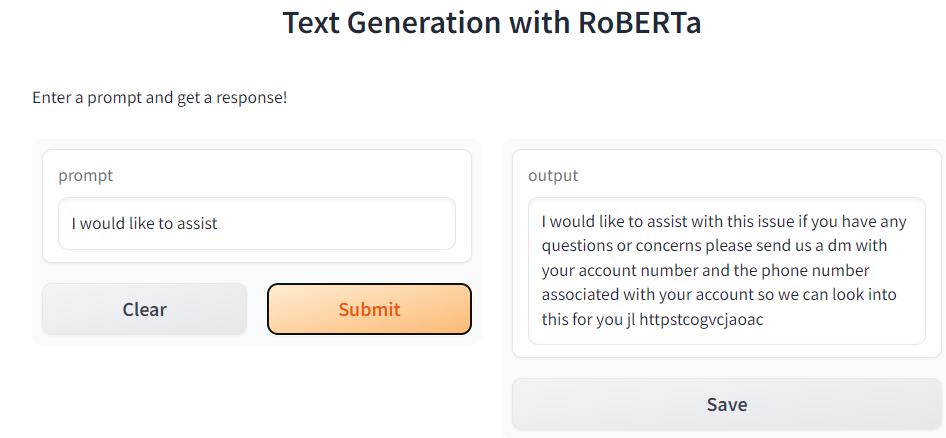